<a href="https://colab.research.google.com/github/lorenzo1285/Econometria/blob/main/arima.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importacion de Paqueterias

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pmdarima as pm
from datetime import datetime
from datetime import timedelta
from statsmodels.tools.eval_measures import rmse
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from time import time
from sklearn.preprocessing import MinMaxScaler
sns.set_style("whitegrid")
%matplotlib inline

# Carga de datos

In [ ]:
df = pd.read_excel('balaza comercial.xlsx')
df.head()

,Fecha,VAL_USD
0,2012-01-01,37597.547
1,2012-02-01,38595.389
2,2012-03-01,41356.070
3,2012-04-01,37700.602
4,2012-05-01,39545.208


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129 entries, 0 to 128
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Fecha    129 non-null    datetime64[ns]
 1   VAL_USD  129 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 2.1 KB


# Preparacion de datos

In [ ]:
df.set_index('Fecha', inplace=True)
df.index = pd.to_datetime(df.index)
df.head()

,VAL_USD
Fecha,
2012-01-01,37597.547
2012-02-01,38595.389
2012-03-01,41356.070
2012-04-01,37700.602
2012-05-01,39545.208


# Visualizacion de datos

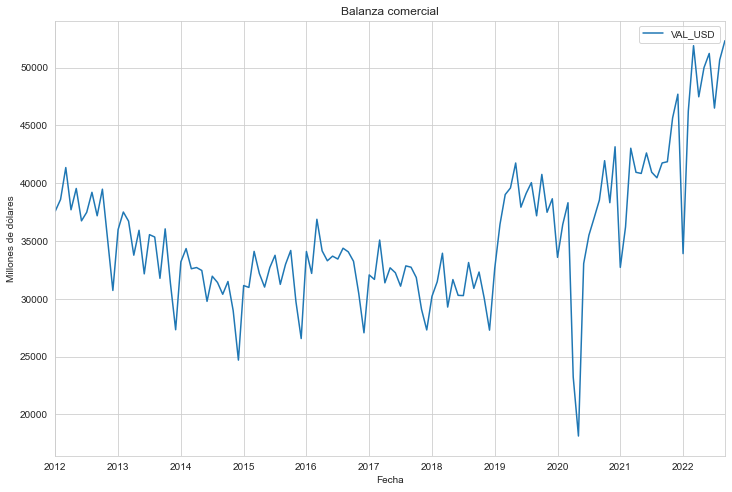

In [ ]:
df.plot(figsize=(12,8))
plt.title('Balanza comercial')
plt.ylabel('Millones de dólares')
plt.xlabel('Fecha')
plt.show()

# Determinacion de Estacionalidad

In [ ]:
def fuller_test(data):
    
    print(" > Is the data stationary ?")
    dftest = adfuller(data, autolag='AIC')
    print("Test statistic = {:.3f}".format(dftest[0]))
    print("P-value = {:.3f}".format(dftest[1]))
    print("Critical values :")
    for k, v in dftest[4].items():
        print("\t{}: {} - The data is {} stationary with {}% confidence".format(k, v, "not" if v<dftest[0] else "", 100-int(k[:-1])))

In [ ]:
fuller_test(df)

 > Is the data stationary ?
Test statistic = 0.454
P-value = 0.983
Critical values :
	1%: -3.4885349695076844 - The data is not stationary with 99% confidence
	5%: -2.887019521656941 - The data is not stationary with 95% confidence
	10%: -2.5803597920604915 - The data is not stationary with 90% confidence


# Autocorrelograma

In [ ]:
def autocorrelation_plot(data):
    fig, ax = plt.subplots(3, figsize=(12,6))
    ax[0] = plot_acf(data.dropna(), ax=ax[0], lags=24,)
    ax[1] = plot_pacf(data.dropna(), ax=ax[1], lags=24)
    ax[2] = data.plot(ax=ax[2])

c:\Users\LorenzoCardenas\anaconda3\envs\VS\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


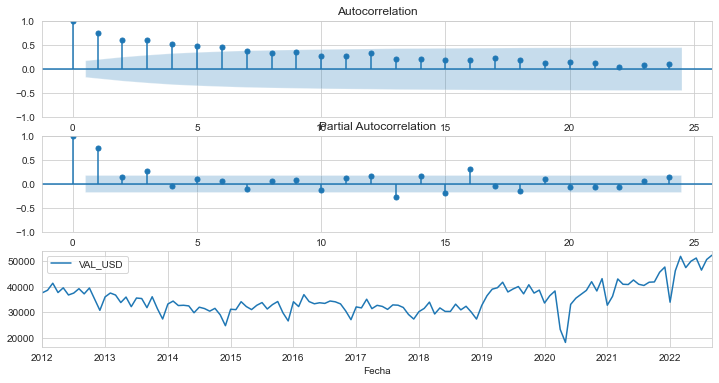

In [ ]:
autocorrelation_plot(df)

# Descomposicion de la serie

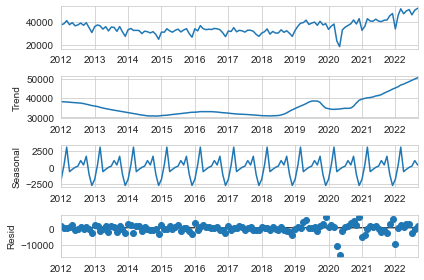

In [ ]:
ts_decomposed = seasonal_decompose(df ,model='additive',extrapolate_trend=True)
ts_trend = ts_decomposed.trend
ts_seasonal = ts_decomposed.seasonal
ts_residual = ts_decomposed.resid
ts_decomposed.plot()
plt.show()



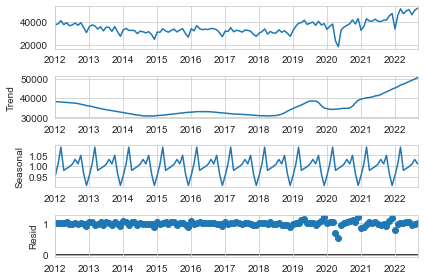

In [ ]:
ts_decomposed = seasonal_decompose(df ,model='multiplicative',extrapolate_trend=True)
ts_trend = ts_decomposed.trend
ts_seasonal = ts_decomposed.seasonal
ts_residual = ts_decomposed.resid
ts_decomposed.plot()
plt.show()